In [30]:
import matplotlib.pyplot as plt
import numpy as np
from gillespie.gillespie import gillespie_ssa
from gillespie.gillespie_dynamic import gillespie_dynamic

from joblib import cpu_count, Parallel, delayed

### Optional asyncronous progressbar

In [31]:
import sys
import contextlib
import joblib
from tqdm.auto import tqdm as tqdm_auto  # <- use auto, not autonotebook


@contextlib.contextmanager
def tqdm_joblib(*args, **kwargs):
    """
    Patch joblib to report into a single tqdm progress bar.

    Yields
    ------
    tqdm object
        You can use it as a normal tqdm instance if needed.
    """
    tqdm_object = tqdm_auto(*args, **kwargs)

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *a, **k):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*a, **k)

    old_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()


def ParallelPbar(desc: str | None = None, total: int | None = None, **tqdm_kwargs):
    """
    Return a joblib.Parallel subclass that shows a tqdm progress bar.

    Parameters
    ----------
    desc : str or None
        tqdm description.
    total : int or None
        Total number of tasks. If None, we try len(iterable); if that fails we
        materialize the iterable to a list as a fallback.
    **tqdm_kwargs :
        Any extra tqdm kwargs (leave, position, disable, etc.).
    """
    class Parallel(joblib.Parallel):
        def __call__(self, iterable):
            local_iter = iterable
            local_total = total
            if local_total is None:
                try:
                    local_total = len(iterable)  # works for sequences
                except TypeError:
                    # last-resort: make a list only if needed
                    local_iter = list(iterable)
                    local_total = len(local_iter)

            with tqdm_joblib(total=local_total, desc=desc, **tqdm_kwargs):
                return super().__call__(local_iter)

    return Parallel

## Parallel gillespie_dynamic run

In [32]:
def run_one_sim(seed: int, reagent_quantity, state_change_vectors, combinatorics,
                max_iter, set_fixed_reagents, start_with):
    # IMPORTANT: make each worker's RNG independent
    np.random.seed(seed)

    sim = gillespie_dynamic(
        reagent_quantity=reagent_quantity,
        state_change_vectors=state_change_vectors,
        combinatorics=combinatorics,
        max_iteration=max_iter,
        set_fixed_reagents=set_fixed_reagents,
        stop_condition="iterations",
        start_with=start_with
    )

    # Return only what's needed
    return {
        "seed": seed,
        "t": np.asarray(sim.timestep_list, dtype=float),
        "X": np.asarray(sim.molecular_species_history, dtype=float),  # shape (t, n_species)
        "time_tracker": sim.time_tracker,
        "iterations": sim.actual_iteration,
    }

In [33]:
# data for Schogle model |  WORKING!!!!!!!!!!!!!!!!!!!!!!
# Paper: NUMERICAL SOLUTION OF STOCHASTIC MODELS OF BIOCHEMICAL KINETICS
# Authors: SILVANA ILIE, WAYNE H. ENRIGHT AND KENNETH R. JACKSON

# Quantities for reagents a,b,x
reag_quant = [100000, 200000, 250]

# reaction stoichiometries
state_change_vect = {"default": [[-1, 0, +1],
                                 [+1, 0, -1],
                                 [0, -1, +1],
                                 [0, +1, -1]]}

# reaction combinatorics (including reaction constants)
combinatorics = {"default": [lambda a,b,x : (3*10e-8*a*x*(x-1)/2),
                             lambda a,b,x : (0.0001*x*(x-1)*(x-2)/6),
                             lambda a,b,x : b*0.001,
                             lambda a,b,x : x*3.5]}

In [17]:
n_cores = cpu_count()
n_sims = 50 # hom many separate simulation to run

deterministic = True # if use a deterministic seed or a (pseudo)random seed
if deterministic:
    seeds = [i for i in range(n_sims)]
else:
    seeds = np.random.randint(low=0, high=10**10, size=n_sims)
    
max_iter = 100000 # number of iterations of each simulation
set_fixed_reagents = [0,1]
start_with = "default"
verbose = True


In [10]:
with tqdm_joblib(total=len(seeds), desc="Running simulations", disable=not verbose) as pbar:
    runs = Parallel(n_jobs=n_cores, backend="loky")(
        delayed(run_one_sim)(seed, reag_quant, state_change_vect, combinatorics, max_iter, set_fixed_reagents, start_with) for seed in seeds
    )

Running simulations:   0%|          | 0/50 [00:00<?, ?it/s]

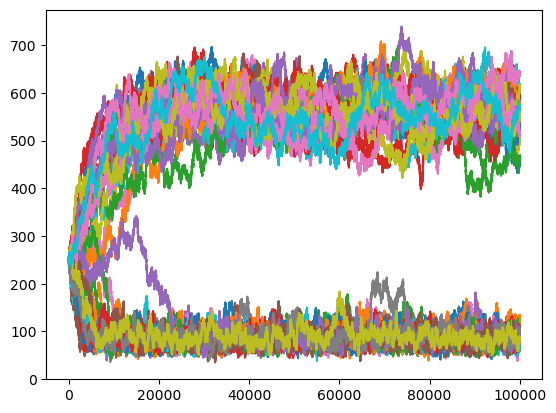

Actual state is: default, actual iteration is: 0, simulation time is 0, real time is: Fri Jan  9 13:59:36 2026.
Actual state is: default, actual iteration is: 0, simulation time is 0, real time is: Fri Jan  9 13:59:40 2026.
Actual state is: default, actual iteration is: 0, simulation time is 0, real time is: Fri Jan  9 13:59:44 2026.
Actual state is: default, actual iteration is: 0, simulation time is 0, real time is: Fri Jan  9 13:59:48 2026.
Actual state is: default, actual iteration is: 0, simulation time is 0, real time is: Fri Jan  9 13:59:52 2026.
Actual state is: default, actual iteration is: 0, simulation time is 0, real time is: Fri Jan  9 13:59:57 2026.
Actual state is: default, actual iteration is: 0, simulation time is 0, real time is: Fri Jan  9 13:59:36 2026.
Actual state is: default, actual iteration is: 0, simulation time is 0, real time is: Fri Jan  9 13:59:40 2026.
Actual state is: default, actual iteration is: 0, simulation time is 0, real time is: Fri Jan  9 13:59:4

In [11]:
for singlerun in runs:
    plt.plot([i for i in range(singlerun["iterations"]+1)], [e[-1] for e in singlerun["X"]])

# Old way: Gillespie single state implementation

In [12]:
# data for Schogle model |  WORKING!!!!!!!!!!!!!!!!!!!!!!
# Paper: NUMERICAL SOLUTION OF STOCHASTIC MODELS OF BIOCHEMICAL KINETICS
# Authors: SILVANA ILIE, WAYNE H. ENRIGHT AND KENNETH R. JACKSON


# Quantities for reagents a,b,x
reag_quant = [100000, 200000, 250]
# reaction stoichiometries
state_change_vect = [[-1, 0, +1],
                     [+1, 0, -1],
                     [0, -1, +1],
                     [0, +1, -1]]
# reaction combinatorics (including reaction constants)
combinatorics = [lambda a,b,x : (3*10e-8*a*x*(x-1)/2),
                lambda a,b,x : (0.0001*x*(x-1)*(x-2)/6),
                lambda a,b,x : b*0.001,
                lambda a,b,x : x*3.5]

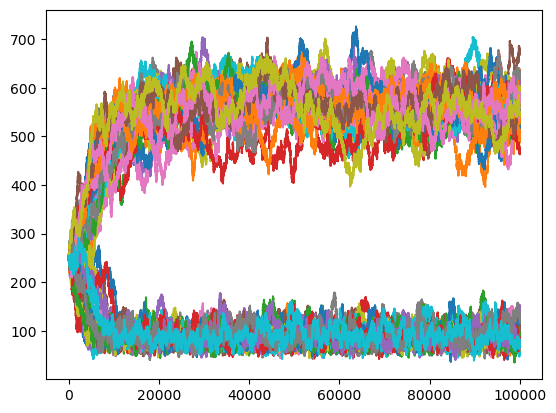

In [3]:
%%time
result_dict ={}
for epoch in range(50):
    
    a = gillespie_ssa(reagent_quantity=reag_quant,
                      state_change_vectors=state_change_vect,
                      combinatorics=combinatorics,
                      iteration=100000,
                      set_fixed_reagents=[0,1])
    result_dict[epoch] = [a.timestep_list, a.molecular_species_history]
    plt.plot([x for x in range(a.actual_iteration+1)],[y[2] for y in a.molecular_species_history])